# Regularization in Logistic Regression


Here I will explore the regularization in Logistic Regression

The data:

- I use a data that has 5 informative features. 
- 3 columns are collinear with the first informative column.
- 4 random data columns:

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

# Create 5 informative columns
X_informative, y = make_classification(
    n_samples=200,
    n_classes=2,
    n_features=5,
    n_informative=5,
    n_redundant=0,
    random_state=42,
)

## Create 3 non-informative columns
random_columns = np.random.rand(200, 3)

# ## Create 4 columns of linear combination of existing 5 columns
# weights = np.random.rand(5, 4)
# linear_comb_columns = X_informative @ weights

### Create 3 columns as linear combination of the first informative column
weights_single_feature = np.random.rand(1, 3)  # Shape (1,3)
linear_comb_single_feature = (
    X_informative[:, [0]] @ weights_single_feature
)  # (200,1) @ (1,3) -> (200,3)


X = np.hstack([linear_comb_single_feature, X_informative, random_columns])

## OLS Logistic Regression

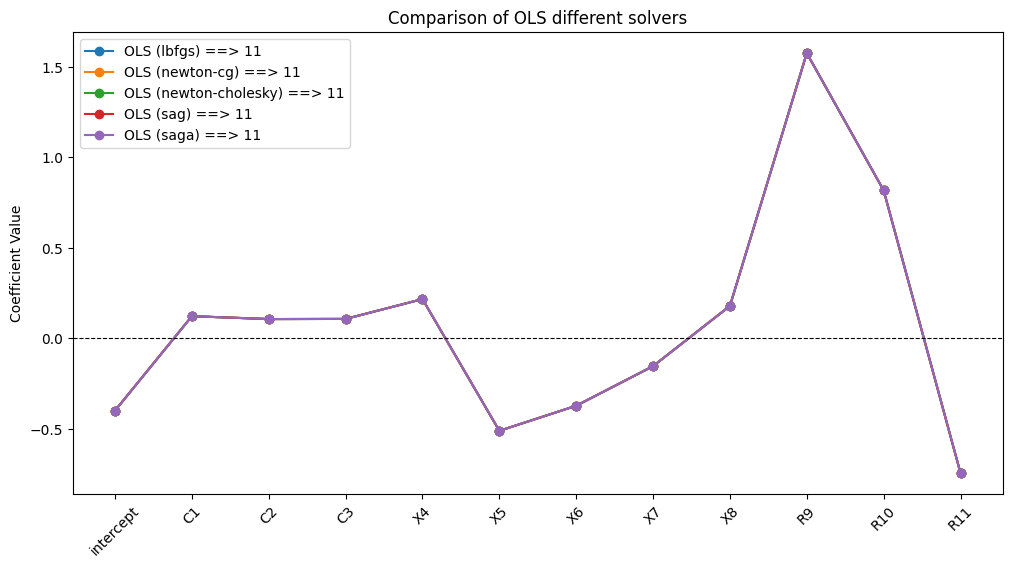

In [ ]:
solvers = ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]

ols_coefs = []

for solver in solvers:
    clf = LogisticRegression(penalty=None, solver="saga")
    clf.fit(X, y)

    ols_coefs += [np.append(clf.intercept_, clf.coef_)]


plt.figure(figsize=(12, 6))

for i, solver in enumerate(solvers):
    non_zero_coef = sum([x != 0 for x in ols_coefs[i][1:]])
    label = f"OLS ({solver}) ==> {non_zero_coef}"
    plt.plot(ols_coefs[i], marker="o", linestyle="-", label=label)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.xticks(
    range(X.shape[1] + 1),
    ["intercept"]
    + [f"{'C' if i<3 else ('X' if i<8 else 'R')}{i+1}" for i in range(X.shape[1])],
    rotation=45,
)
plt.ylabel("Coefficient Value")
plt.title("Comparison of OLS different solvers")
plt.legend()
plt.show()

- All Solvers are coming with the same number of significant features (11)
- Interestingly, random features have the highest coefficient.

Saga works for L1, L2 and no regularization. I'll continue with `saga` solver.

## LASSO

Lasso is cool for feature selection; Let's evaluate the power of the regularization of Lasso 

Note that in the sklearn LogReg implementation `C` is the reverse regularization. 

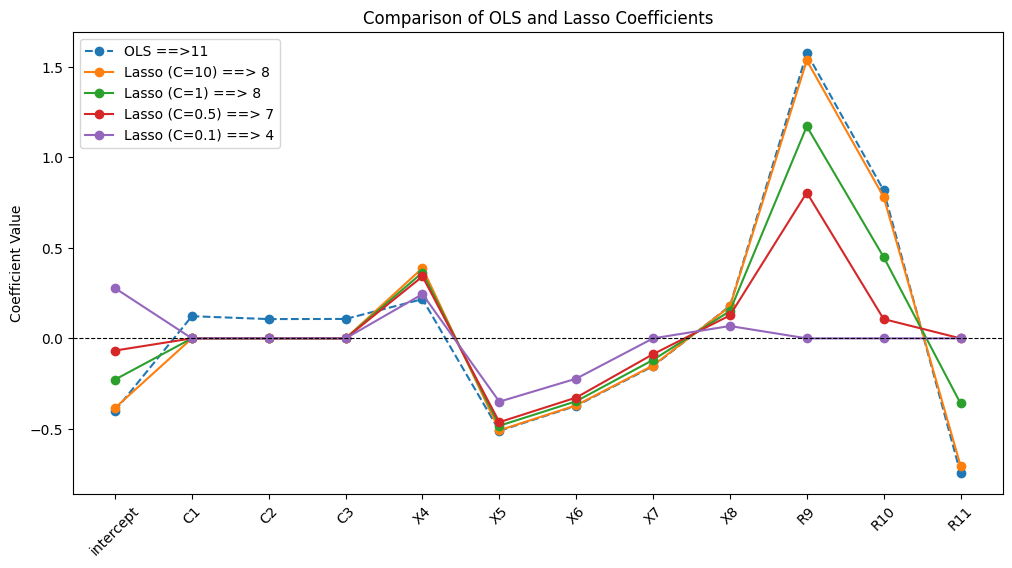

In [8]:

# C values are reverse regularization; smaller value: higher regularization 
regularization = [10, 1, .5, .1]

l1_coefs = []

for reg_power in regularization:
    clf = LogisticRegression(penalty='l1', C = reg_power, solver='saga', max_iter=10000, random_state=42) 
    clf.fit(X, y)
    l1_coefs += [np.append(clf.intercept_, clf.coef_)]


plt.figure(figsize=(12, 6))

plt.plot(ols_coefs[-1], marker='o', linestyle='--', label=f'OLS ==>{sum([x!=0 for x in ols_coefs[-1][1:]])}')

for i, reg_power in enumerate(regularization):
    non_zero_coef = sum([x!=0 for x in l1_coefs[i][1:]])
    label = f'Lasso (C={reg_power}) ==> {non_zero_coef}'
    plt.plot(l1_coefs[i], marker='o', linestyle='-', label=label)

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xticks(range(X.shape[1] + 1), ['intercept'] + [f"{'C' if i<3 else ('X' if i<8 else 'R')}{i+1}" for i in range(X.shape[1])], rotation=45)
plt.ylabel("Coefficient Value")
plt.title("Comparison of OLS and Lasso Coefficients")
plt.legend()
plt.show()

- increase in regularization power (lower C values), yields to fewer features. 
- with all regularization values, collinear features get removed. 
  - interestingly, `X4` which was the basis for C1, C2, and C3 columns will be maintained. 
- with strong regularization (C=.1), random variables will also be removed (as well as X7!!!)

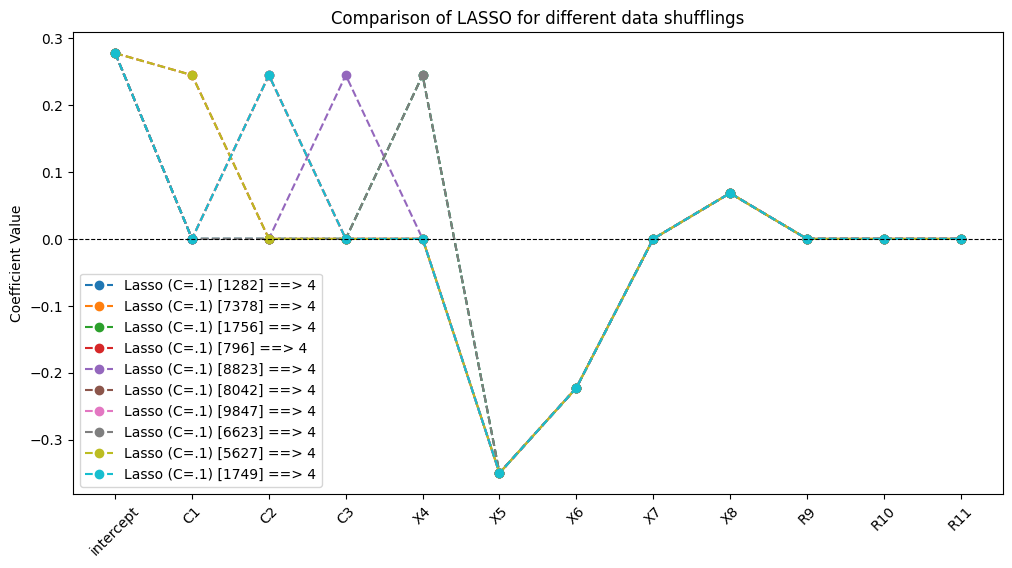

In [9]:
# running Lasso multiple times to see if X4 get removed instead of C1/2/3 ?

l1_coefs = []

rand_states = np.random.randint(1, 10000, size=10)


for rnd_state in rand_states:
    clf = LogisticRegression(
        penalty="l1", C=0.1, solver="saga", max_iter=10000, random_state=rnd_state
    )
    shuffled_indices = np.append(
        ## Shuffle the first 4 collumn indices
        np.random.permutation(range(4)), 
        # maintain the rest of collum orderings
        range(4, 11)
    )
    X_shuffled = X[:, shuffled_indices]  # Apply shuffling
    clf.fit(X_shuffled, y)
    l1_coefs += [np.append(clf.intercept_, clf.coef_)]


plt.figure(figsize=(12, 6))

# plt.plot(ols_coef, marker='o', linestyle='-', label=f'OLS ==>{sum([x!=0 for x in ols_coef[1:]])}')

for i, rnd_state in enumerate(rand_states):
    non_zero_coef = sum([x != 0 for x in l1_coefs[i][1:]])
    label = f"Lasso (C=.1) [{rnd_state}] ==> {non_zero_coef}"
    plt.plot(l1_coefs[i], marker="o", linestyle="--", label=label)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.xticks(
    range(X.shape[1] + 1),
    ["intercept"]
    + [f"{'C' if i<3 else ('X' if i<8 else 'R')}{i+1}" for i in range(X.shape[1])],
    rotation=45,
)
plt.ylabel("Coefficient Value")
plt.title("Comparison of LASSO for different data shufflings")
plt.legend()
plt.show()

- Different random seeds and shufflings will maintain different "copies" of the first informative feature. 